# Common Variables

In [1]:
from pathlib import Path


DATA_PATH = Path('../data/')
SHRUNKEN_PATH = DATA_PATH / 'shrunken/'

# check if global variables are defined
if '_train_data' not in globals():
    _train_data = None

if '_train_bb' not in globals():
    _train_bb = None

if '_test_data' not in globals():
    _test_data = None

if '_test_bb' not in globals():
    _test_bb = None

# Dataset Utils

In [2]:
import polars as pl
import pyarrow.parquet as pq
from pandas import DataFrame
import pickle

def get_train_data() -> DataFrame:
    global _train_data

    if _train_data is not None:
        print("Using cached train data...")
        return _train_data
    
    print("Reading train data...")
    _train_data = pl.read_parquet(SHRUNKEN_PATH / "train.parquet").to_pandas(use_pyarrow_extension_array=True)
    return _train_data

def get_train_building_blocks() -> dict[str, dict[int, str]]:
    global _train_bb

    if _train_bb is not None:
        print("Using cached building blocks...")
        return _train_bb

    print("Reading building blocks...")
    _train_bb = {
        "bb1": pickle.load(open(SHRUNKEN_PATH / "train_dicts/BBs_dict_reverse_1.p", "rb")),
        "bb2": pickle.load(open(SHRUNKEN_PATH / "train_dicts/BBs_dict_reverse_2.p", "rb")),
        "bb3": pickle.load(open(SHRUNKEN_PATH / "train_dicts/BBs_dict_reverse_3.p", "rb")),
    }
    return _train_bb

def get_test_data() -> DataFrame:
    global _test_data

    if _test_data is not None:
        print("Using cached test data...")
        return _test_data
    
    print("Reading test data...")
    _test_data = pl.read_parquet(SHRUNKEN_PATH / "test.parquet").to_pandas(use_pyarrow_extension_array=True)
    return _test_data

def get_test_building_blocks() -> dict[str, dict[int, str]]:
    global _test_bb

    if _test_bb is not None:
        print("Using cached building blocks...")
        return _test_bb

    print("Reading building blocks...")
    _test_bb = {
        "bb1": pickle.load(open(SHRUNKEN_PATH / "test_dicts/BBs_dict_reverse_1_test.p", "rb")),
        "bb2": pickle.load(open(SHRUNKEN_PATH / "test_dicts/BBs_dict_reverse_2_test.p", "rb")),
        "bb3": pickle.load(open(SHRUNKEN_PATH / "test_dicts/BBs_dict_reverse_3_test.p", "rb")),
    }
    return _test_bb

# Calculate Productivity of each BuildingBlock

In [3]:
from tqdm import tqdm
from dataclasses import dataclass
import pickle

data = get_train_data()

@dataclass
class BBInfo:
    id: int
    num_molecules: int = 0
    num_active_brd4: int = 0
    num_active_hsa: int = 0
    num_active_seh: int = 0

    @property
    def productivity_brd4(self) -> float:
        return self.num_active_brd4 / self.num_molecules

    @property
    def productivity_hsa(self) -> float:
        return self.num_active_hsa / self.num_molecules

    @property
    def productivity_seh(self) -> float:
        return self.num_active_seh / self.num_molecules
    
def calculate_bb_info(data: DataFrame, bb_column: str) -> list[BBInfo]:
    bb_info: list[BBInfo] = [BBInfo(id) for id in sorted(data[bb_column].unique().tolist())]
    for idx in tqdm(range(len(bb_info))):
        id = bb_info[idx].id
        temp = data[(data[bb_column] == id)]
        bb_info[idx].num_molecules = temp.shape[0]
        bb_info[idx].num_active_seh = temp[temp["binds_sEH"] == True].shape[0]
        bb_info[idx].num_active_hsa = temp[temp["binds_HSA"] == True].shape[0]
        bb_info[idx].num_active_brd4 = temp[temp["binds_BRD4"] == True].shape[0]

_bb: list[tuple[str, str]] = [("buildingblock1_smiles", "bb1_info.pkl"), ("buildingblock2_smiles", "bb2_info.pkl"), ("buildingblock3_smiles", "bb3_info.pkl")]
bb_info: list[list[BBInfo]] = []
for bb_column, filename in _bb:
    if not (DATA_PATH / filename).exists():
        bb_info_single = calculate_bb_info(data, bb_column)
        with open(DATA_PATH / filename, "wb") as f:
            pickle.dump(bb_info_single, f)
        bb_info.append(bb_info_single)
    else:
        with open(DATA_PATH / filename, "rb") as f:
            bb_info.append(pickle.load(f))

Reading train data...


In [4]:
# data = get_train_data()

# for bb in [1, 2, 3]:
#     data[f"productivity_bb{bb}_sEH"] = data["buildingblock1_smiles"].apply(lambda x: bb_info[bb-1][x].productivity_seh)
#     print("Done")
#     data[f"productivity_bb{bb}_HSA"] = data["buildingblock1_smiles"].apply(lambda x: bb_info[bb-1][x].productivity_hsa)
#     print("Done")
#     data[f"productivity_bb{bb}_BRD4"] = data["buildingblock1_smiles"].apply(lambda x: bb_info[bb-1][x].productivity_brd4)
#     print("Done")

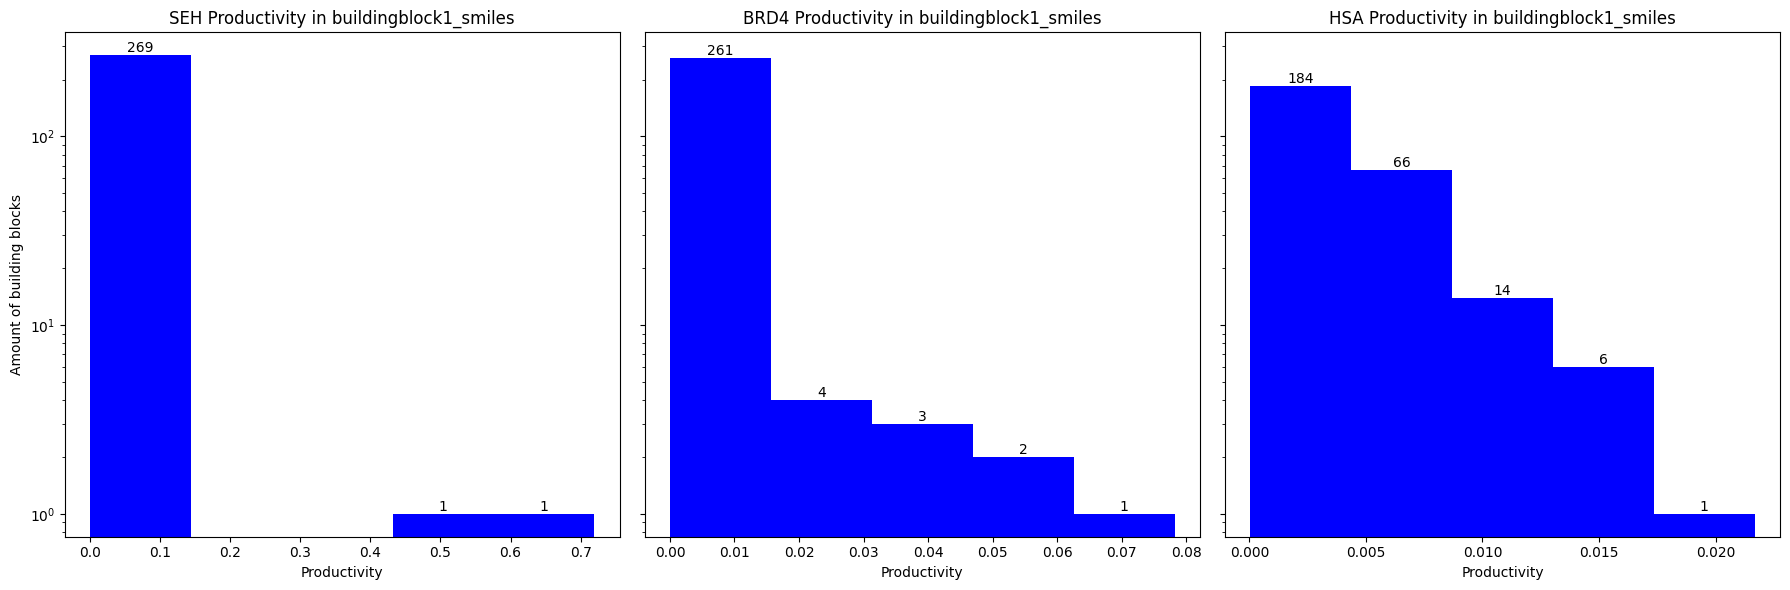

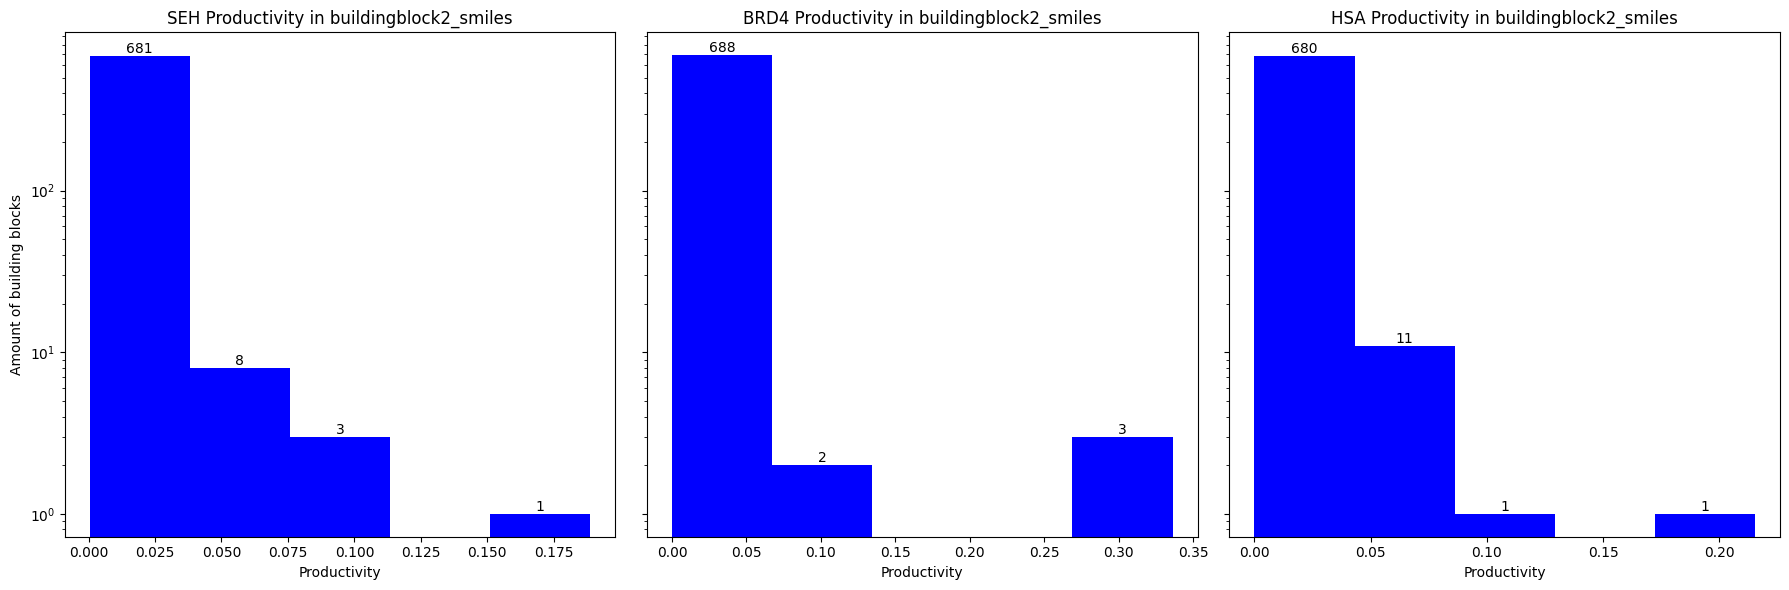

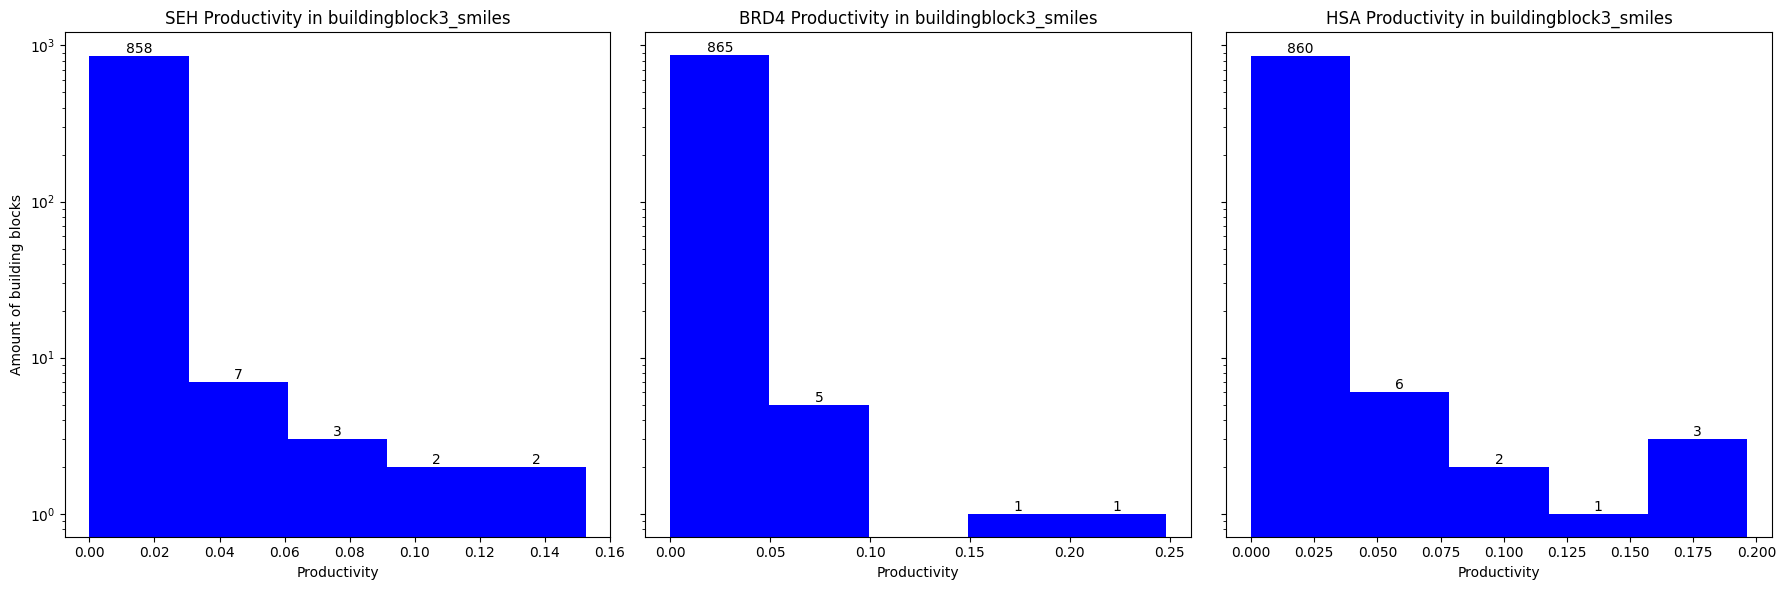

In [5]:
# Plot the productivity of each building block
import matplotlib.pyplot as plt

# Assuming _bb and bb_info are available in your context
for idx, (bb_column, _) in enumerate(_bb):
    productivity_seh = [bb.productivity_seh for bb in bb_info[idx]]
    productivity_brd4 = [bb.productivity_brd4 for bb in bb_info[idx]]
    productivity_hsa = [bb.productivity_hsa for bb in bb_info[idx]]
    
    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Plot for productivity_seh
    counts, bins, patches = axs[0].hist(productivity_seh, bins=5, log=True, color='blue')
    axs[0].set_title(f"SEH Productivity in {bb_column}")
    axs[0].set_xlabel("Productivity")
    axs[0].set_ylabel("Amount of building blocks")
    for count, bin, patch in zip(counts, bins, patches):
        height = patch.get_height()
        if height > 0:
            axs[0].text(patch.get_x() + patch.get_width() / 2, height, str(int(count)),
                        ha='center', va='bottom', fontsize=10, color='black')
    
    # Plot for productivity_brd4
    counts, bins, patches = axs[1].hist(productivity_brd4, bins=5, log=True, color='blue')
    axs[1].set_title(f"BRD4 Productivity in {bb_column}")
    axs[1].set_xlabel("Productivity")
    for count, bin, patch in zip(counts, bins, patches):
        height = patch.get_height()
        if height > 0:
            axs[1].text(patch.get_x() + patch.get_width() / 2, height, str(int(count)),
                        ha='center', va='bottom', fontsize=10, color='black')
    
    # Plot for productivity_hsa
    counts, bins, patches = axs[2].hist(productivity_hsa, bins=5, log=True, color='blue')
    axs[2].set_title(f"HSA Productivity in {bb_column}")
    axs[2].set_xlabel("Productivity")
    for count, bin, patch in zip(counts, bins, patches):
        height = patch.get_height()
        if height > 0:
            axs[2].text(patch.get_x() + patch.get_width() / 2, height, str(int(count)),
                        ha='center', va='bottom', fontsize=10, color='black')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



# Calculate Similarity of each BuildingBlock

Reading building blocks...
Reading building blocks...


100%|██████████| 186966/186966 [08:06<00:00, 384.30it/s]


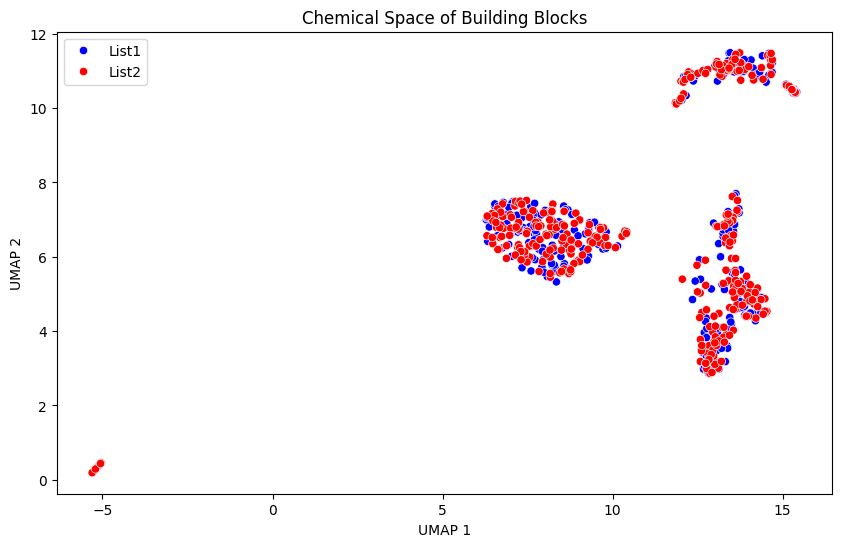

In [6]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolAlign, rdmolops
from rdkit.Chem.rdShapeHelpers import ShapeTanimotoDist
from rdkit.Chem import DataStructs
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from tqdm import tqdm

bb1_train = list(get_train_building_blocks()["bb1"].values())
bb1_test = list(get_test_building_blocks()["bb1"].values())

def calculate_tanimoto_combo(mol1, mol2):
    # Generate conformers
    mol1 = Chem.AddHs(mol1)
    mol2 = Chem.AddHs(mol2)

    AllChem.EmbedMolecule(mol1)
    AllChem.EmbedMolecule(mol2)

    # Align molecules and calculate shape similarity
    shape_dist = ShapeTanimotoDist(mol1, mol2)
    
    # Calculate color similarity using fingerprints
    fp1 = AllChem.GetMorganFingerprint(mol1, 2)
    fp2 = AllChem.GetMorganFingerprint(mol2, 2)
    color_sim = DataStructs.TanimotoSimilarity(fp1, fp2)
    
    # Tanimoto combo score
    tanimoto_combo = shape_dist + color_sim
    return tanimoto_combo

def calculate_tanimoto_combo_parallel(i, j, molecules):
    sim = calculate_tanimoto_combo(molecules[i], molecules[j])
    return i, j, sim

def cluster_smiles(smiles_list1, smiles_list2):

    if not (DATA_PATH / 'sim_matrix.p').exists():
        smiles_list = smiles_list1 + smiles_list2
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
        
        # Calculate similarity matrix
        n = len(molecules)
        sim_matrix = np.zeros((n, n))
        
        pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(calculate_tanimoto_combo_parallel, i, j, molecules) for i, j in pairs]
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
                i, j, sim = future.result()
                sim_matrix[i, j] = sim
                sim_matrix[j, i] = sim

        with open(DATA_PATH / 'sim_matrix.p', 'wb') as f:
            pickle.dump(sim_matrix, f)
    
    else:
        with open(DATA_PATH / 'sim_matrix.p', 'rb') as f:
            sim_matrix = pickle.load(f)

    # Transform similarity matrix to distances
    dist_matrix = 1 - sim_matrix
    
    # Apply UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(dist_matrix)
    
    # Plotting
    labels = ['List1'] * len(smiles_list1) + ['List2'] * len(smiles_list2)
    df = pd.DataFrame(embedding, columns=['x', 'y'])
    df['label'] = labels
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='x', y='y', hue='label', data=df, palette=['blue', 'red'])
    plt.title('Chemical Space of Building Blocks')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.show()

cluster_smiles(bb1_train, bb1_test)